## 6 Linear models

Linear models work well in real-world. However, they have certain disadvantages:
  1. Prediction accuracy: the coefficient estimates have high variance, especially if # of samples n is comparable to # of predictors p.
  2. Interpretability: large # of predictors p can make interpreting models difficult.

These disadvantages can be overcome by techniques like:
  1. subset selection or feature selection
  2. shrinkage or regularization
  3. dimensionality reduction

### 6.1 Subset selection

From among the p predictors, choose a subset of predictors that have strong relationship with the response and discard others.
Available methods are:
  1. Best subset selection: 
      - each predictor is either chosen or not. for p predictors, 2^p models are possible. Choose the best one.
      - can be computationally intensive/impossible for large p.
      - for p = 20, greater than 1M models are possible.
  2. Forward stepwise selection: 
      - algorithm:
                1. start with a null model.
                2. At each of the k = p steps, add the best predictor to the chosen subset. Call this Mk.
                3. choose the best among the Mk models using AIC, BIC, adjusted R2 or cross-validation.
      - only p+1 models need to be fit, so computationally less intensive than best subset.
      - at each step, the best predictor for that step is chosen greedily -> can lead to sub-optimal predictors.
  3. Backward stepwise selection: 
      - similar to forward stepwise selection, but reverse.
      - start with all the predictors. At each of the k = p steps, drop the worst predictor. Call this Mk.
  4. Hybird selection:
      - a combination of forward and reverse stepwise selection models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
credit = pd.read_csv('../data/Credit.csv', index_col=0).dropna()
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
X = pd.get_dummies(credit.drop(columns=['Balance']),
                  drop_first=True)
y = credit.Balance
lm1 = sm.OLS(y, sm.add_constant(X)).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     750.3
Date:                Thu, 31 Dec 2020   Prob (F-statistic):          1.11e-253
Time:                        00:03:11   Log-Likelihood:                -2398.7
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     388   BIC:                             4869.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -489.8611    

As can be seen from the above summary results, not all predictors are significant in predicting the response. It appears that, in the presence of other predictors, Education, Gender, Marital status and Ethinicity aren't significant. Subset selection methods can be used to select the best subset of predictors.

#### Choosing optimal model
Training error is not a good estimate for test error. For example, if we keep adding more predictors, training error will keep on decreasing, but test error might not. Test error follows a U-shape, based on bias-variance trade-off. So we need a way to estimate test error accurately. Available methods are:
1. Modify the training error to better estimate the test error.
    - use metrics like Cp, AIC, BIC, adjusted R2.
2. Use corss-validation
    - LOO or k-fold CV

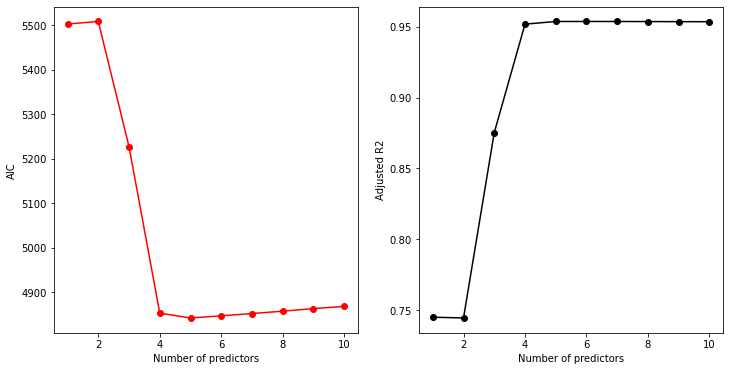

In [12]:
# text book fits 2^p models and chooses a best model Mk for each of the k=0,1,...,p predictors
# it then plots cp, bic and adjusted R2 scores for these best models Mk, k=0,1,...p
# Instead, I use sklearn to select k best features and input the selected features to OLS
# I am NOT SURE IF THIS IS EVEN WORKING!!
from sklearn.feature_selection import SelectKBest, f_regression

aic_scores, r2_scores = [], []
for k in range(1, len(X.columns)):
    X_new = SelectKBest(score_func=f_regression, k=k).fit_transform(X, y)
    model = sm.OLS(y, sm.add_constant(X_new)).fit()
    aic_scores.append(model.bic)
    r2_scores.append(model.rsquared_adj)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(range(1, len(X.columns)), aic_scores, 'r-o');
ax[0].set_xlabel('Number of predictors')
ax[0].set_ylabel('AIC')
ax[1].plot(range(1, len(X.columns)), r2_scores, 'k-o')
ax[1].set_xlabel('Number of predictors')
ax[1].set_ylabel('Adjusted R2');

## Shrinkage or Regularization

The variance observed in the coefficient estimates of OLS models can be reduced by shrinking the coefficients towards zero. This improves prediction accuracy by reducing variance. Some of the coefficients can be set to zero. This improves model interpretability. Two popular methods are:
   1. Ridge regression
   2. Lasso

### Ridge regression
- adds l2-norm of coefficient vector to the OLS' RSS and minimizes the combined term.
    - The additional term is called shrinkage penalty.
- the amount of penalty is controlled by a tunable parameter lambda.
    - when lambda = 0, ridge is the same as OLS.
    - when lambda = inf, the coefficients tend toward zero.
- ALWAYS, scale the predictors before feeding them to ridge.
- ridge works because it tries to substantially reduce the variance of a OLS model, at the expense of increased bias.
- the lambda parameter needs careful selection.

In [5]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

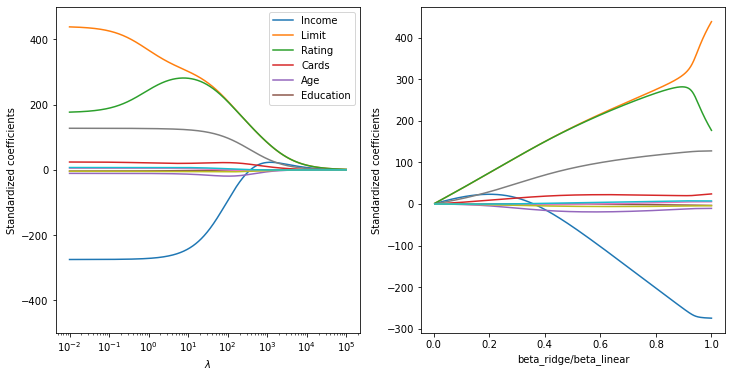

In [6]:
X = pd.get_dummies(credit.drop(columns=['Balance']),
                  drop_first=True)
y = credit.Balance

X_scaled = StandardScaler().fit_transform(X) # does this scale the dummy variables too?
# yes, it does scale the dummy/categorical variables; but it doesn't seem to
# change the result much. In this cell, I scale all the predictors (numeric & categorical)
# In the cell below this one, I scale ONLY numeric variables and the results
# look a bit DIFFERENT

rid_reg = Ridge()

alphas = np.logspace(-2, 5, 1000)
coeffs, l2_norms = [], []
for a in alphas:
    rid_reg.set_params(alpha=a)
    rid_reg.fit(X_scaled, y)
    coeffs.append(rid_reg.coef_)
    l2_norms.append(np.linalg.norm(rid_reg.coef_)) #l2-norm of coef vector
coeffs = np.array(coeffs)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# left plot
ax[0].set_xscale('log')
ax[0].set_ylim([-500, 500])
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    if i < 6: # lables/legend clutters the map, so add it for some variables only
        ax[0].plot(alphas, coeffs[:, i], label=X.columns[i])
    else:
        ax[0].plot(alphas, coeffs[:, i])
ax[0].set_ylabel('Standardized coefficients')
ax[0].set_xlabel('$\lambda$')
ax[0].legend();
# right plot
l2_norms = l2_norms / l2_norms[0] # normalize wrt. linear coefficients
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    ax[1].plot(l2_norms, coeffs[:, i])
ax[1].set_xlabel('beta_ridge/beta_linear')
ax[1].set_ylabel('Standardized coefficients');

In the left hand panel:
  1. as $\lambda$ increases, all the coefficients tend towards zero.
  2. the left end of the plot is OLS estimates.

In the right hand panel:
  1. As we move from left to right, shrinkage decreases.

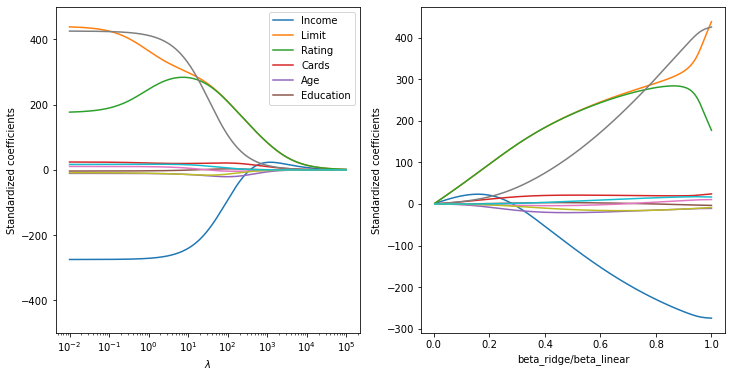

In [7]:
# ridge regression, but with only numeric predictors scaled
X = pd.get_dummies(credit.drop(columns=['Balance']),
                  drop_first=True)
y = credit.Balance

X_num = X.iloc[:, :6]
X_cat = X.iloc[:, 6:]
X_num_scaled = StandardScaler().fit_transform(X_num)
X_new = np.c_[X_num_scaled, X_cat]

alphas = np.logspace(-2, 5, 1000)
coeffs, l2_norms = [], []
for a in alphas:
    rid_reg.set_params(alpha=a)
    rid_reg.fit(X_new, y)
    coeffs.append(rid_reg.coef_)
    l2_norms.append(np.linalg.norm(rid_reg.coef_)) #l2-norm of coef vector
coeffs = np.array(coeffs)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# left plot
ax[0].set_xscale('log')
ax[0].set_ylim([-500, 500])
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    if i < 6: # lables/legend clutters the map, so add it for some variables only
        ax[0].plot(alphas, coeffs[:, i], label=X.columns[i])
    else:
        ax[0].plot(alphas, coeffs[:, i])
ax[0].set_ylabel('Standardized coefficients')
ax[0].set_xlabel('$\lambda$')
ax[0].legend();
# right plot
l2_norms = l2_norms / l2_norms[0] # normalize wrt. linear coefficients
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    ax[1].plot(l2_norms, coeffs[:, i])
ax[1].set_xlabel('beta_ridge/beta_linear')
ax[1].set_ylabel('Standardized coefficients');

### LASSO
- Similar to ridge regression. Lasso adds l1-norm to OLS's RSS, instead of ridge's l2-norm.
- Lasso sets some coefficients to 0, for large lambda. So, it performs feature selection.
- Like ridge, lambda parameter needs careful selection.

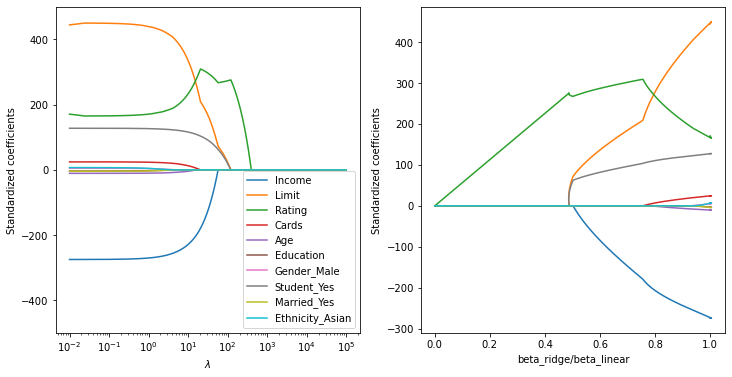

In [8]:
alphas = np.logspace(-2, 5, 1000)
coeffs, l2_norms = [], []
rid_reg = Lasso()

for a in alphas:
    rid_reg.set_params(alpha=a)
    rid_reg.fit(X_scaled, y) # change X_scaled to X_new to scale just the numeric predictors
    coeffs.append(rid_reg.coef_)
    l2_norms.append(np.linalg.norm(rid_reg.coef_)) #l2-norm of coef vector
coeffs = np.array(coeffs)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# left plot
ax[0].set_xscale('log')
ax[0].set_ylim([-500, 500])
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    if i < 61: # lables/legend clutters the map, so add it for some variables only
        ax[0].plot(alphas, coeffs[:, i], label=X.columns[i])
    else:
        ax[0].plot(alphas, coeffs[:, i])
ax[0].set_ylabel('Standardized coefficients')
ax[0].set_xlabel('$\lambda$')
ax[0].legend();
# right plot
l2_norms = l2_norms / l2_norms[0] # normalize wrt. linear coefficients
for i in range(len(coeffs[0, 1:])): # drop the intercept, so 1:
    ax[1].plot(l2_norms, coeffs[:, i])
ax[1].set_xlabel('beta_ridge/beta_linear')
ax[1].set_ylabel('Standardized coefficients');

### ridge vs. lasso
Neither ridge regression nor the lasso
will universally dominate the other. In general, one might expect the lasso
to perform better in a setting where a relatively small number of predictors
have substantial coefficients, and the remaining predictors have coefficients
that are very small or that equal zero. Ridge regression will perform better
when the response is a function of many predictors, all with coefficients of
roughly equal size. However, the number of predictors that is related to the
response is never known a priori for real data sets. A technique such as
cross-validation can be used in order to determine which approach is better
on a particular data set.

### selecting the tuning parameter $labmda$

selecting the tuning parameter $\lambda$ is an important step in ridge and lasso. Use cross-validation.

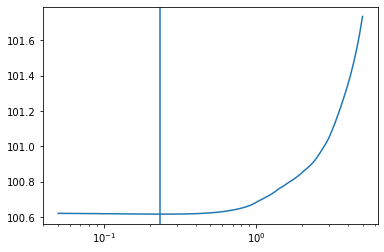

In [9]:
from sklearn.model_selection import cross_val_score
model = Lasso()

mse, coeffs = [], []
alphas = np.logspace(-2, 0, 100) * 5
for a in alphas:
    model.set_params(alpha=a)
    scores = cross_val_score(model, X_scaled, y, cv=10, scoring='neg_mean_squared_error')
    mse.append(np.sqrt(np.mean(-scores)))


plt.plot(alphas, mse)
least = alphas[np.argmin(mse)]
plt.axvline(least)
plt.xscale('log');

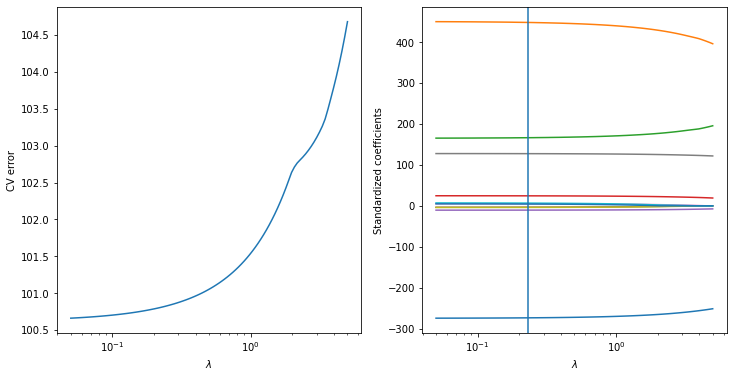

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

model = Lasso()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse, coeffs = [], []
alphas = np.logspace(-2, 0, 100) * 5
for a in alphas:
    model.set_params(alpha=a)
    for train_idx, valid_idx in kf.split(X_scaled, y):
        X_train, y_train = X_scaled[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X_scaled[valid_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)
        error = mean_squared_error(y_valid, model.predict(X_valid))
        #coeffs.append(model.coef_) # this 'collects' alphas * n_splits coef_
    coeffs.append(model.fit(X_scaled, y).coef_) # refit the model with full data
    mse.append(np.sqrt(np.mean(error)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(alphas, mse)
ax[0].set_xscale('log')
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('CV error')
ax[1].plot(alphas, coeffs)
ax[1].set_xscale('log')
ax[1].set_xlabel('$\lambda$')
ax[1].axvline(least)
ax[1].set_ylabel('Standardized coefficients');

In this PARTICULAR case, the CV error curve is quite flat, and the lambda that minimizes CV error is quite small, indicating that optimal fit involves only a small amount of shrinkage over the OLS fit. This can be seen from the right hand panel of the above figure too, where at the chosen lambda, the coefficients are only slightly shrinked compared ot OLS coefficients. 

## Dimension reduction
